## Load libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline

## Process datasets

### Merge the dataset 20171129
1. Merge the dataset to point_spread.csv and matches.csv
2. Unify the team name
  * JAX -> JAC (NFL use JAX, but just for unification)
  * Buffalo -> BUF
  * LAC -> SD
  * LA -> STL

### Read feature datasets 
from 2009 to 2017

In [6]:
colnames = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']

In [7]:
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=colnames)
    data = pd.concat([data, d])
data.shape

(388476, 12)

### Merge point spread data

In [23]:
spread = pd.read_csv('data/point_spread.csv')

# Transform spread data to dictionary for matching
# spread = dict([(i, (h, v, f, u, c)) for i, h, v, f, u, c in zip(spread.eid, spread.Home, spread.Away, spread.Favorite, spread.Underdog, spread.CoverOrNot)])

In [24]:
## TODO: Match point spread data with each spread
##       This is stupidly slow, fix it!
## CAUTION: Post season resides in point spread data, be aware of them!
# for i, r in data.iterrows():
# #     if r.GameID in spread: # TODO: complexity?
#     cover = spread[r.GameID]
#     data.loc[i, 'Favorite'] = cover[2]
#     data.loc[i, 'Underdog'] = cover[3]
#     data.loc[i, 'CoverOrNot'] = cover[4]
#     print 'process', i

### Deal with missing data

In [71]:
data = data.dropna(axis=0, how='any')

In [72]:
data.shape

(330202, 12)

In [73]:
data = data[data['TimeSecs'] >= 0]

In [74]:
data.shape

(327847, 12)

#### Columns to include in the formation of buckets [Down, TimeSecs, YdsToGo and Score Diff]

In [23]:
data['homeScoreDiff'] = data[['posteam','ScoreDiff','HomeTeam']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['HomeTeam'] else (-x['ScoreDiff']),axis=1)

The range of each variable
- down = [1,4] Four buckets from here
- ydstogo = [0,100] 10 buckets from here
- homeScoreDiff = [-60, 60] 30 buckets from here 
- TimeSecs = [0,3600] 180 buckets from here

Total buckets = 180\*30\*10\*4 = 216000

### Notes 
1. Count a minute a bucket: [0,3600] -> 60 buckets
2. Add a flag bucket for who possessing the ball, favorite or underdog


In [24]:
data['DownClass'] = pd.cut(data['down'],4, labels=False)

In [25]:
data['TimeSecsClass'] = pd.cut(data['TimeSecs'],180, labels=False)

In [26]:
data['yrdline100Class'] = pd.cut(data['yrdline100'],10, labels=False)

In [27]:
data['homeScoreDiffClass'] = pd.cut(data['homeScoreDiff'],30, labels=False)

In [28]:
class_names = ['homeScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass']

In [29]:
temp = data.groupby(class_names).size().reset_index(name='counts')

In [30]:
temp.head()

,homeScoreDiffClass,yrdline100Class,TimeSecsClass,DownClass,counts
0,0,0,40,0,1
1,0,0,44,2,1
2,0,0,44,3,1
3,0,0,45,1,1
4,0,0,47,0,1


Now temp contains the count of each existing class. From here, we've to add 0 for values of the classes that don't exist. The following code does that.

In [31]:
new_table = pd.pivot_table(temp,
                           index=class_names,
                           values='counts',
                           fill_value = 0,
                           dropna=False,
                           aggfunc=np.sum)

new_table stores the count for each class.

In [32]:
counts = list(new_table['counts'])

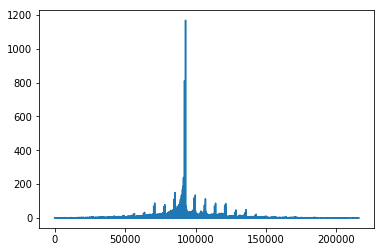

In [33]:
plt.plot(counts)

Total Classes = 216000

Classes with zero values = 139214

Classes with non zero values = 76786

In [34]:
temp.shape

(67047, 5)

In [38]:
data.iloc[100]

GameID                2009091000
Drive                         18
qtr                            3
down                           1
TimeSecs                    1208
yrdline100                    90
posteam                      TEN
DefensiveTeam                PIT
sp                             0
ScoreDiff                      0
HomeTeam                     PIT
AwayTeam                     TEN
homeScoreDiff                 -0
DownClass                      0
TimeSecsClass                 84
yrdline100Class                9
homeScoreDiffClass            12
Name: 112, dtype: object

### Plot the relation along different features

In [48]:
# data_p = data[data["GameID"]]
avai_idx = [int(str(eid)[:4]) > 2012 for eid in data["GameID"]]
data.iloc[avai_idx]

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,HomeTeam,AwayTeam,homeScoreDiff,DownClass,TimeSecsClass,yrdline100Class,homeScoreDiffClass
1,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,DEN,BAL,-0.0,0,179,8,12
2,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,DEN,BAL,-0.0,1,178,8,12
3,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,DEN,BAL,-0.0,2,176,7,12
4,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,DEN,BAL,-0.0,3,175,7,12
5,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,DEN,BAL,0.0,0,175,7,12
6,2013090500,2,1,2.0,3485.0,77.0,DEN,BAL,0,0.0,DEN,BAL,0.0,1,175,7,12
7,2013090500,2,1,3.0,3445.0,76.0,DEN,BAL,0,0.0,DEN,BAL,0.0,2,173,7,12
8,2013090500,2,1,1.0,3424.0,66.0,DEN,BAL,0,0.0,DEN,BAL,0.0,0,172,6,12
9,2013090500,2,1,2.0,3418.0,66.0,DEN,BAL,0,0.0,DEN,BAL,0.0,1,172,6,12
10,2013090500,2,1,3.0,3384.0,59.0,DEN,BAL,0,0.0,DEN,BAL,0.0,2,171,5,12
